In [1]:
%matplotlib inline
import numpy as np
import networkx as nx

from scipy.misc import comb

## Confirming rewire stats from Flache and Macy 2011

I'm trying to confirm my implementation is working like Flache and Macy's.
Part of this is to confirm my random connection additions are working similarly. Two main claims need to be recreated. First, at the beginning of Section 3.1 of the paper, they say that with a probability of .003 they connect two previously disconnected pairs of agents. "Averaged across 50 realizations, 28.75 undirected new network ties were added by this procedure, an average increase of the density of about .006. First, let's just check their math.

In [2]:
# number of possible edges
n_possible = comb(100, 2)
# number of edges in disconnected caves
n_in_caves = 20 * comb(5, 2)
# total number of disconnected edges in initial configuration
n_disconnected = n_possible - n_in_caves

print(n_possible)
print(n_in_caves)
print(n_disconnected)
print()
print('28.75/n_disconnected = {:.4f}'.format(28.75/n_disconnected))

4950.0
200.0
4750.0

28.75/n_disconnected = 0.0061


So it appears the probability was instead .006. This mirrors another concern I had, which was whether or not the density of my networks was matching theirs. They claim the density increased by an average of .006 in their 50 trials. Let's do this trial and calculate the average.

In [3]:
from macy import Network, caves

def test_rewired_density(n_trials=50, add_cxn_prob=.003):

    results = np.zeros((int(n_trials),))
    for i in range(int(n_trials)):
        c = caves(20, 5)
        n = Network(c)
        pre_rewire_density = nx.density(n.graph)
        n.add_random_connections(conn_prob=add_cxn_prob)
        results[i] = nx.density(n.graph) - pre_rewire_density

    return np.mean(results)


print('add connection probability = .003\naverage density change: {}'.format(
        test_rewired_density(n_trials=100, add_cxn_prob=.003))
      )

print('add connection probability = .006\naverage density change: {}'.format(
        test_rewired_density(n_trials=100, add_cxn_prob=.006)))

add connection probability = .003
average density change: 0.002973737373737372
add connection probability = .006
average density change: 0.005719191919191918


### What is going on?

I believe Flache and Macy are giving a .003 chance to $(a_1, a_2)$ to get an edge, then giving a .003 of adding an edge between $(a_2, a_1)$, even though they are the same thing. I remove symmetric pairs since they are
identical in the context of an edge. So I will use a probability of .006 that a given edge will be added in my quest to reproduce Flach and Macy's results.

### Number of disconnected graphs that result

Flache and Macy say "we found that on average about four out of 20 caves remained unconnected." We can count the number of disconnected caves by finding all subgraphs with exactly five connected agents.

In [4]:
from collections import Counter

def test_disconnected_cave_count(n_trials=50, add_cxn_prob=.006):
    results = np.zeros((int(n_trials),))
    for i in range(int(n_trials)):
        c = caves(20, 5)
        n = Network(c)
        n.add_random_connections(conn_prob=add_cxn_prob)
        
        component_counts = Counter(
            len(el) for el in list(nx.connected_components(n.graph))
        )
        if 5 in component_counts:
            results[i] = component_counts[5]
            
    return np.mean(results)

probs = np.arange(.001, .009, .001)
disconnected_caves = [
        test_disconnected_cave_count(100, prob)
        for prob in probs
     ]

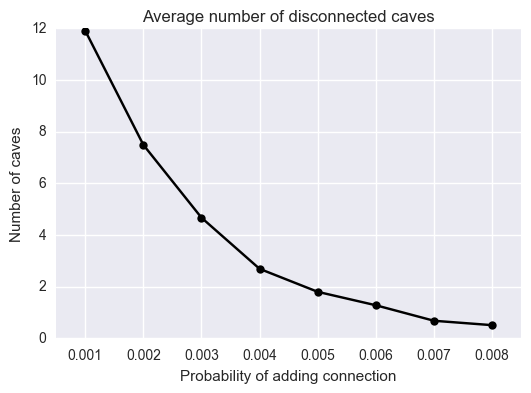

In [5]:
plt.plot(probs, disconnected_caves, 'o-', ms=6, color='black', mfc='black')
plt.xlim([.0005, .0085])
plt.title('Average number of disconnected caves')
plt.ylabel('Number of caves')
plt.xlabel('Probability of adding connection')

It appears the number of caves they say are disconnected on average actually corresponds to a probability of .003. 

## Conclusion

I don't believe I have any bugs in my code, and at this point I do believe there is some inconsistency in the Flache and Macy results for the graph topologies they see. My guess is that for most of the paper they were inadvertantly doubling the probability of selecting an edge by counting pairs of nodes twice. Then, later, maybe at the request of a reviewer, they did the average cave calculation. Or, they just looked at a few results and said "on average...about...".

I will go ahead with a probability of .006 for my models to match graph densities.